In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,],
        std=[0.5,],
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=True)

In [7]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


## 1 Layer epsilon Softmax MLP

In [8]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
#         dists = dists/(torch.norm(dists, dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists + self.scaler)
        dists = 1-dists*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [9]:
class DTeSM(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0, itemp=10):
        super().__init__(input_dim, output_dim, bias=False, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=itemp, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        
    def forward(self, x):
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_activ = xo.data
#         return xo[:, :-1]
        return xo

In [10]:
DTeSM(2, 5, 0.1)(torch.randn(1, 2)).shape

torch.Size([1, 6])

In [11]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim0, hidden_dim1, output_dim, epsilon0=1.0, epsilon1=1.0):
        super().__init__()
        
        self.layer0 = DTeSM(input_dim, hidden_dim0, epsilon=epsilon0, itemp=1.0)
        
        if epsilon0 is not None:
            hidden_dim0 += 1
        
        self.layer1 = DTeSM(hidden_dim0, hidden_dim1, epsilon=epsilon1, itemp=3.0)
        
        if epsilon1 is not None:
            hidden_dim1 += 1
        
#         self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
#         self.activ = nn.ReLU()

        self.layer2 = nn.Linear(hidden_dim1, output_dim)
        pass
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.layer1(xo)
        xo = self.layer2(xo)
        return xo

In [12]:
h0 = 200
# h1 = 60
h1 = 100
model = LocalMLP_epsilonsoftmax(784, h0, h1, 10, epsilon0=20.0, epsilon1=5.0)

In [13]:
model.to(device)

LocalMLP_epsilonsoftmax(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer2): Linear(in_features=101, out_features=10, bias=True)
)

In [14]:
d1 = super(DistanceTransform_Epsilon, model.layer1).forward(model.layer0(xx.reshape(-1, 28*28)))
d1.mean(), d1.std(), d1.min(), d1.max()

(tensor(4.7535, grad_fn=<MeanBackward0>),
 tensor(0.2176, grad_fn=<StdBackward0>),
 tensor(4.2989, grad_fn=<MinBackward1>),
 tensor(5.2952, grad_fn=<MaxBackward1>))

In [15]:
def get_random_training_samples(N):
    new_center = []
    new_labels = []
    count = 0
    for i, (xx, yy) in enumerate(train_loader):
        xx = xx.reshape(xx.shape[0], -1)
        if count+xx.shape[0] < N:
            new_center.append(xx)
            new_labels.append(yy)
            count += xx.shape[0]
        elif count >= N:
            break
        else:
            new_center.append(xx[:N-count])
            new_labels.append(yy[:N-count])
            count = N
            break

    new_center = torch.cat(new_center, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    
    weights = torch.zeros(len(new_labels), 10)
    for i in range(len(new_labels)):
        weights[i, new_labels[i]] = 1.
    
    return new_center.to(device), weights.to(device)

In [16]:
# get_random_training_samples(2)

In [17]:
c0, _ = get_random_training_samples(h0)

In [18]:
## first layer
model.layer0.centers.data = c0.to(model.layer0.centers.device)

In [19]:
c1, v1 = get_random_training_samples(h1)

In [20]:
v1.shape

torch.Size([100, 10])

In [21]:
## second layer
model.layer1.centers.data = model.layer0(c1.to(device))
if model.layer1.epsilon is not None:
    e = torch.ones(1, v1.shape[1])*0
    v1 = torch.cat([v1, e], dim=0)
    
model.layer2.weight.data = v1.t().to(device)

In [22]:
model.layer1.centers.data.max(dim=1)[1] #### This is the problem for multilayer rejection

tensor([199,  46,  85,  67, 133,  54, 185, 119,  94,  29, 123, 157, 200, 172,
          2,  40, 141, 172,  66,  58, 101,  23, 150,  73,  94, 141,   0,  13,
         62,  66,  44, 197, 150,   8,  76,  74, 160, 114,  59, 180,  26, 120,
        144,  38,  53,  42,  66,  26,  99,  27,  40, 165,  24, 177, 104, 181,
          3,   0,  64,  30,  12, 173,  76,  79, 115,  50, 157,  47,  67,  82,
          5, 119,  82,  15, 115, 104, 188,  50,   8,   8,  26, 175,  10, 117,
        134, 101,   0,  90,  10,  15,   2, 193,  25, 181,   0,  60, 185, 162,
         64,  44])

In [23]:
model(xx.reshape(-1, 28*28)).shape

torch.Size([50, 10])

In [24]:
asdasd

NameError: name 'asdasd' is not defined

In [25]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        
        ### Train with random image and "10" as class
#         inputs = torch.cat([inputs, torch.rand(batch_size//10, 28*28, dtype=inputs.dtype).to(device)*2-1], dim=0)
#         targets = torch.cat([targets, torch.ones(batch_size//10, dtype=targets.dtype).to(device)*10], dim=0)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [26]:
best_acc = -1
def test(epoch, model):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    acc = 100.*correct/total
    return acc

In [27]:
model.eval()

LocalMLP_epsilonsoftmax(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer2): Linear(in_features=101, out_features=10, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
test_acc = test(0, model)
test_acc

[Test] 0 Loss: 2.305 | Acc: 9.820 982/10000


9.82

### Model Training - evaluation

In [30]:
learning_rate = 0.01
# EPOCHS = 10
EPOCHS = 2

In [31]:
p1, p2 = [], []
for p in model.named_parameters():
    if p[0].endswith(".centers"):
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*0.03}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [32]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model)
    scheduler.step()
    
"""
Note: It trains to about 95% on MNIST
"""
print()

100%|██████████| 1200/1200 [00:11<00:00, 108.46it/s]

[Train] 0 Loss: 0.897 | Acc: 70.983 42590/60000


[Test] 0 Loss: 0.312 | Acc: 90.960 9096/10000


100%|██████████| 1200/1200 [00:12<00:00, 95.55it/s] 

[Train] 1 Loss: 0.261 | Acc: 92.713 55628/60000


[Test] 1 Loss: 0.233 | Acc: 93.270 9327/10000



## Test for Adverserial Rejection

In [33]:
import foolbox as fb
import foolbox.attacks as fa

In [34]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [41]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    with torch.no_grad():
        yout = model(xx)
    reject0 = model.layer0.temp_activ.max(dim=1)[1] == h0
    reject1 = model.layer1.temp_activ.max(dim=1)[1] == h1
#     reject = torch.bitwise_or(reject0, reject1)
#     reject = torch.bitwise_and(reject0, reject1)
    reject = reject0
    
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)
    with torch.no_grad(): ### just to access neuron activation for adverserial examples
        yout = model(advs)
    reject0 = model.layer0.temp_activ.max(dim=1)[1] == h0
    reject1 = model.layer1.temp_activ.max(dim=1)[1] == h1
#     reject = torch.bitwise_or(reject0, reject1)
#     reject = torch.bitwise_and(reject0, reject1)
    reject = reject0
    
    
    rejected += int(reject.type(torch.float32).sum())
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

100%|██████████| 200/200 [00:02<00:00, 77.53it/s]


In [42]:
count, failed, rejected, x_rejected

(10000, 43, 9896, 8441)

In [43]:
(failed+x_rejected)/count

0.8484

In [44]:
# reject1

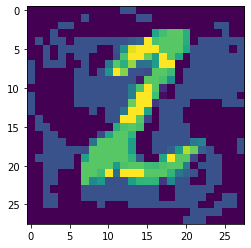

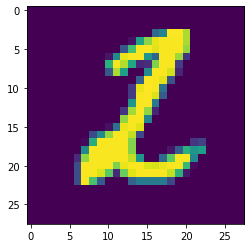

In [45]:
plt.imshow(advs[0].reshape(28,28))
plt.show()
plt.imshow(xx[0].reshape(28,28))
plt.show()

In [46]:
model.layer0.epsilon = 10.0
model.layer1.epsilon = 2.

### Analyze

In [47]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
attack = fa.FGSM()

In [48]:
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    with torch.no_grad():
        yout = model(xx)
    reject0 = model.layer0.temp_activ
    reject1 = model.layer1.temp_activ
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.1)
    with torch.no_grad(): ### just to access neuron activation for adverserial examples
        yout = model(advs)
    _reject0 = model.layer0.temp_activ
    _reject1 = model.layer1.temp_activ
    break

  0%|          | 0/200 [00:00<?, ?it/s]


In [49]:
reject0.max(dim=1)[1]

tensor([200, 200, 147, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 136, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
         30, 200, 200, 200, 200, 200,  60, 200])

In [50]:
_reject0.max(dim=1)[1]

tensor([200, 200, 147, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 136, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
         30, 200, 200, 200, 200, 200, 139, 200])

In [51]:
torch.count_nonzero(reject0.max(dim=1)[1] != _reject0.max(dim=1)[1]) ## num changed elements

tensor(1)

In [52]:
reject1.max(dim=1)[1]

tensor([81, 81,  9, 86, 86, 86, 86, 86, 86, 72, 86, 86, 72, 72, 86, 86, 48, 86,
        86, 48, 33, 48, 48, 86, 86, 67, 81, 83, 72, 59, 86, 81, 48, 86, 86, 48,
        48, 86, 72, 86, 81, 86, 22, 48, 83, 86, 86, 86, 22, 48])

In [53]:
_reject1.max(dim=1)[1]

tensor([81, 81,  9, 86, 86, 86, 86, 48, 86, 72, 86, 86, 72, 72, 86, 86, 48, 86,
        86, 48, 86, 48, 48, 86, 86, 67, 81, 86, 82, 81, 86, 81, 48, 86, 86, 48,
        48, 86, 72, 86, 81, 86, 22, 48, 86, 41, 86, 86, 22, 48])

In [54]:
reject1[0]

tensor([2.4523e-08, 4.7168e-08, 2.0874e-04, 6.9645e-06, 6.0155e-02, 2.2666e-05,
        5.6615e-10, 7.3360e-05, 1.5609e-10, 2.1486e-06, 2.0511e-08, 2.1947e-08,
        1.8529e-05, 1.6527e-04, 5.6255e-07, 4.8054e-10, 1.9433e-04, 2.7907e-03,
        7.3857e-04, 3.4430e-09, 2.5579e-04, 2.5400e-02, 4.8888e-08, 9.5534e-05,
        1.8658e-07, 2.1808e-04, 1.3578e-03, 7.1720e-04, 5.7741e-02, 2.4944e-03,
        4.0905e-04, 6.3832e-06, 1.6758e-10, 5.9255e-04, 1.6968e-05, 1.7880e-05,
        5.4120e-04, 2.0647e-10, 3.1418e-09, 1.1336e-01, 5.2511e-10, 4.2141e-02,
        3.9557e-04, 1.6381e-06, 1.2358e-04, 5.8208e-04, 2.2773e-01, 9.5568e-10,
        5.3888e-03, 2.6257e-06, 7.0738e-06, 8.5563e-05, 9.5788e-04, 2.7225e-09,
        2.8969e-03, 9.0384e-05, 3.0670e-04, 3.1689e-03, 1.4847e-10, 7.6193e-10,
        8.0246e-03, 3.2848e-04, 5.6505e-05, 1.4291e-07, 2.1582e-05, 1.3250e-03,
        3.2928e-09, 1.4068e-03, 1.8088e-06, 3.8148e-04, 1.3477e-10, 1.5241e-03,
        7.9394e-03, 4.6428e-10, 9.9034e-

In [55]:
_reject1[0]

tensor([9.3740e-08, 2.0263e-07, 5.6070e-04, 1.7922e-05, 6.2139e-02, 4.1768e-05,
        3.1933e-09, 1.8092e-04, 9.6321e-10, 6.9309e-06, 7.8051e-08, 8.5070e-08,
        3.6469e-05, 3.7655e-04, 1.6466e-06, 2.7399e-09, 5.0810e-04, 4.8638e-03,
        1.5527e-03, 1.5064e-08, 6.9359e-04, 2.5628e-02, 1.7391e-07, 2.8423e-04,
        7.3123e-07, 5.6159e-04, 2.6548e-03, 1.8791e-03, 5.4017e-02, 5.0892e-03,
        9.5041e-04, 1.2646e-05, 1.0288e-09, 1.2426e-03, 2.9739e-05, 3.2908e-05,
        1.4608e-03, 1.2483e-09, 1.5908e-08, 9.6714e-02, 2.9763e-09, 7.4721e-02,
        8.8210e-04, 4.5707e-06, 3.4968e-04, 8.0729e-04, 1.7118e-01, 5.2077e-09,
        1.2876e-02, 5.5073e-06, 1.3312e-05, 1.4665e-04, 1.9534e-03, 1.0524e-08,
        4.6764e-03, 2.7709e-04, 4.9760e-04, 5.3275e-03, 9.1956e-10, 3.5950e-09,
        8.5316e-03, 9.1500e-04, 8.9728e-05, 4.4756e-07, 3.9209e-05, 2.4703e-03,
        1.4160e-08, 2.7876e-03, 3.9559e-06, 8.9228e-04, 8.4095e-10, 2.8229e-03,
        1.5903e-02, 2.0277e-09, 1.9799e-

In [ ]:
"""
Problem:
Even some inputs will produce very high value for epsilon neuron (more than adverserial example)
Hence, layer1 regards it as non-adverserial (no epsilon is maximized for adverserial example)

Solution -> do not forward propagate the epsilon neuron (just use it for rejection) -> needs large code change
        -> Or use residual layer.. (dtSM might have very skewed representation- difficult to disintangle..)


Problem:
Epsilon in second layer changes the adverserial examples.


It requires more understanding... maybe different approach... (maybe non-normalized DT-eSM)
        --- Try Solution in 02.12 (replace /std with /norm)
        --- Try to use threshold value in epsilon rather than argmax !!
"""

In [ ]:
a = 4e-10

In [56]:
reject1[:, -1], _reject1[:, -1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
torch.count_nonzero(reject1[:, -1] > a)

In [ ]:
torch.count_nonzero(_reject1[:, -1] > a)